# 2. Pruning

This notebook demonstrates how to prune a model using the `torh.torch.nn.utils.prune` and `torch-pruning` library. Pruning is a technique to reduce the size of a neural network by removing weights that are deemed unnecessary, which can lead to faster inference times and reduced memory usage.

There is 2 types of pruning:
- **Unstructured pruning**: Removes individual weights using an importance metric (e.g., low-magnitude weights are pruned). This can lead to sparse models, which reduce drastically the number of parameters but must rely on specialized hardware and/or libraries to take advantage of the sparsity during inference.
- **Structured pruning**: Removes entire channels or layers, using a metric measuring an entire channel or layer importance (e.g., low-magnitude channels are pruned). This leads to a more regular model that can be used on standard hardware without requiring specialized libraries.

Metrics used for pruning are typically based on the magnitude of weights, gradients, or other statistics that indicate the importance of a weight or a channel.

The process is defined as such:
* A Torch model is loaded.
* A pruning strategy is defined, which specifies how to prune the model (e.g., unstructured or structured pruning, and the importance metric to use).
* The model is pruned using the defined strategy.
* The model is exported PyTorch format for further optimization or deployment.

2 pruning methods will be used in this notebook, both for 2 models (image and audio classification):
* L1-magntiude unstructured pruning using `torch.torch.nn.utils.prune`.
* L1-magnitude structured pruning using `torch-pruning`.

# Setup

In [1]:
from typing import Any

import torch

from matplotlib import pyplot as plt

from nnopt.model.utils import count_parameters
from nnopt.model.eval import eval_model
from nnopt.model.prune import prune_finetune
from nnopt.model.const import DEVICE, DTYPE, AMP_ENABLE

from nnopt.recipes.mobilenetv2_cifar10 import load_mobilenetv2_cifar10_model, get_cifar10_datasets, save_mobilenetv2_cifar10_model

2025-06-13 12:28:23,220 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Using device: cuda, dtype: torch.bfloat16


In [2]:
# MobilenetV2 CIFAR-10 model
mobilenetv2_cifar10_baseline, mobilenetv2_cifar10_baseline_metadata = load_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/fp32/baseline")

# CIFAR-10 datasets
cifar10_train_dataset, cifar10_val_dataset, cifar10_test_dataset = get_cifar10_datasets()

2025-06-13 12:28:23,227 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 12:28:23,228 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.9254, 'avg_loss': 0.21455251355171204, 'samples_per_second': 9594.238581494608, 'avg_time_per_batch': 0.006596786050597328, 'avg_time_per_sample': 0.00010422921959943779, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9288, 'avg_loss': 0.20640371625423432, 'samples_per_second': 9116.575566348814, 'avg_time_per_batch': 0.006986643948966146, 'avg_time_per_sample': 0.00010969030999876849, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 

# L1 unstructured pruning

In [3]:
# Prune using L1 unstructured pruning, finetune, and evaluate for 0.5, 0.7, and 0.9 sparsity levels
unstruct_pruned_amount_model_version_map: dict[float, str] = {}
unstruct_pruned_amount_metrics_map: dict[float, Any] = {}
for sparsity in [0.5, 0.7, 0.9]:
    print("***" * 20)
    # Prune and finetune the model
    mobilenetv2_cifar10_pruned = prune_finetune(
    model=load_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/fp32/baseline")[0],
    train_dataset=cifar10_train_dataset,
    val_dataset=cifar10_val_dataset,
    pruning_method="l1_unstructured_pruning",
    pruning_amount=sparsity,
    batch_size=64,  # Adjust batch size as needed
    num_epochs=5,
    device=DEVICE,
    use_amp=AMP_ENABLE,
    dtype=DTYPE
)
    version_dir = f"mobilenetv2_cifar10/fp32/l1_unstruct_prune_{sparsity}"
    # Save the model and its metadata
    unstruct_pruned_amount_model_version_map[sparsity] = version_dir
    unstruct_pruned_amount_metrics_map[sparsity] = {
        "val_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_val_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=AMP_ENABLE,
            dtype=DTYPE
        ),
        "test_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_test_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=AMP_ENABLE,
            dtype=DTYPE
        ),
    }
    print(("***" * 20) + "\n")
    save_mobilenetv2_cifar10_model(
        model=mobilenetv2_cifar10_pruned,
        version=version_dir,
        unstruct_sparse_config={
            "pruning_amount": sparsity
        },
        metrics_values=unstruct_pruned_amount_metrics_map[sparsity]
    )

2025-06-13 12:28:27,106 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 12:28:27,108 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.9254, 'avg_loss': 0.21455251355171204, 'samples_per_second': 9594.238581494608, 'avg_time_per_batch': 0.006596786050597328, 'avg_time_per_sample': 0.00010422921959943779, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9288, 'avg_loss': 0.20640371625423432, 'samples_per_second': 9116.575566348814, 'avg_time_per_batch': 0.006986643948966146, 'avg_time_per_sample': 0.00010969030999876849, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 

************************************************************


[Warmup]: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]
2025-06-13 12:28:28,501 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 40.92it/s, acc=0.1424, cpu=3.7%, gpu_mem=3.0/24.0GB (12.4%), gpu_util=41.0%, loss=2.9980, ram=4.7/30.9GB (18.5%), samples/s=353.7]  
2025-06-13 12:28:30,437 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.50: 0.1424
2025-06-13 12:28:30,437 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.7409, Accuracy: 0.1424
Throughput: 6691.17 samples/sec | Avg Batch Time: 9.46 ms | Avg Sample Time: 0.15 ms
System Stats: CPU Usage: 9.30% | RAM Usage: 4.5/30.9GB (17.9%) | GPU 0 Util: 41.00% | GPU 0 Mem: 3.0/24.0GB (12.4%)


Epoch 1/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 41.72it/s, acc=0.8564, cpu=3.1%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=37.0%, loss=0.7618, ram=4.8/30.9GB (18.7%), samples/s=1117.1] 


Epoch 1/5, Train Loss: 0.9029, Train Acc: 0.6870, Train Throughput: 1900.63 samples/s | Val Loss: 0.4183, Val Acc: 0.8564, Val Throughput: 7658.40 samples/s | CPU Usage: 10.70% | RAM Usage: 4.6/30.9GB (18.1%) | GPU 0 Util: 31.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 2/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.53it/s, acc=0.8722, cpu=3.1%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=36.0%, loss=0.5925, ram=4.9/30.9GB (19.0%), samples/s=1094.5] 


Epoch 2/5, Train Loss: 0.7811, Train Acc: 0.7293, Train Throughput: 1988.00 samples/s | Val Loss: 0.3716, Val Acc: 0.8722, Val Throughput: 7394.98 samples/s | CPU Usage: 14.30% | RAM Usage: 4.6/30.9GB (18.1%) | GPU 0 Util: 30.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 3/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.41it/s, acc=0.8938, cpu=5.9%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=37.0%, loss=0.9565, ram=4.9/30.9GB (19.0%), samples/s=1083.4] 


Epoch 3/5, Train Loss: 0.7188, Train Acc: 0.7501, Train Throughput: 2004.41 samples/s | Val Loss: 0.3157, Val Acc: 0.8938, Val Throughput: 7317.40 samples/s | CPU Usage: 10.90% | RAM Usage: 4.6/30.9GB (18.1%) | GPU 0 Util: 37.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 4/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 41.52it/s, acc=0.8842, cpu=6.2%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=0.5020, ram=4.9/30.9GB (19.0%), samples/s=1123.3] 


Epoch 4/5, Train Loss: 0.6964, Train Acc: 0.7595, Train Throughput: 1997.13 samples/s | Val Loss: 0.3314, Val Acc: 0.8842, Val Throughput: 7369.70 samples/s | CPU Usage: 11.00% | RAM Usage: 4.6/30.9GB (18.1%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 5/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.81it/s, acc=0.8910, cpu=3.1%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=39.0%, loss=0.9104, ram=4.9/30.9GB (19.0%), samples/s=1129.4] 
2025-06-13 12:31:46,076 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-13 12:31:46,076 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:31:46,079 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 5/5, Train Loss: 0.6798, Train Acc: 0.7659, Train Throughput: 2005.42 samples/s | Val Loss: 0.3269, Val Acc: 0.8910, Val Throughput: 7541.28 samples/s | CPU Usage: 10.10% | RAM Usage: 4.6/30.9GB (18.1%) | GPU 0 Util: 39.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]
2025-06-13 12:31:46,560 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 41.07it/s, acc=0.8910, cpu=3.4%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=39.0%, loss=0.9104, ram=4.9/30.9GB (19.0%), samples/s=1138.0] 
2025-06-13 12:31:48,489 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.8910
2025-06-13 12:31:48,489 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:31:48,492 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-13 12:31:48,493 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-13 12:31:48,493 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:31:48,496 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.3269, Accuracy: 0.8910
Throughput: 7483.07 samples/sec | Avg Batch Time: 8.46 ms | Avg Sample Time: 0.13 ms
System Stats: CPU Usage: 10.30% | RAM Usage: 4.6/30.9GB (18.1%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.58it/s]
2025-06-13 12:31:48,902 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 40.89it/s, acc=0.8910, cpu=3.7%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=0.9104, ram=4.9/30.9GB (19.0%), samples/s=1354.0]  
2025-06-13 12:31:50,838 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:31:50,841 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.3269, Accuracy: 0.8910
Throughput: 9173.38 samples/sec | Avg Batch Time: 6.90 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 10.80% | RAM Usage: 4.6/30.9GB (18.1%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.79it/s]
2025-06-13 12:31:51,291 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 43.01it/s, acc=0.8905, cpu=2.4%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=37.0%, loss=0.2148, ram=4.9/30.9GB (19.1%), samples/s=697.4]  
2025-06-13 12:31:54,993 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.5/model.pt
2025-06-13 12:31:55,032 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model state_dict saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.5/state_dict.pt
2025-06-13 12:31:55,032 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.5/metadata.json
2025-06-13 12:31:55,033 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:31:55,034 - nnopt.mo

Evaluation Complete: Avg Loss: 0.3294, Accuracy: 0.8905
Throughput: 8862.14 samples/sec | Avg Batch Time: 7.19 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 12.70% | RAM Usage: 4.6/30.9GB (18.2%) | GPU 0 Util: 33.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)
************************************************************



2025-06-13 12:31:55,346 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT script model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.5/jit_script.pt
2025-06-13 12:31:55,346 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Saving model in JIT trace format...
2025-06-13 12:31:56,130 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.5/jit_trace.pt
2025-06-13 12:31:56,134 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 12:31:56,135 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.9254, 'avg_loss': 0.21455251355171204, 'samples_per_second': 9594.238581494608, 'avg_time_per_batch': 0.006596786050597328, 'avg_time_per_sample': 0.00010422921959943779, 'params_stats': {'int_weig

************************************************************


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]
2025-06-13 12:31:58,453 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 41.37it/s, acc=0.0946, cpu=3.2%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=40.0%, loss=2.5889, ram=5.0/30.9GB (19.6%), samples/s=1097.8] 
2025-06-13 12:32:00,368 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.70: 0.0946
2025-06-13 12:32:00,369 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.5527, Accuracy: 0.0946
Throughput: 6870.73 samples/sec | Avg Batch Time: 9.21 ms | Avg Sample Time: 0.15 ms
System Stats: CPU Usage: 11.80% | RAM Usage: 4.7/30.9GB (18.6%) | GPU 0 Util: 40.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 1/5 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 39.03it/s, acc=0.8032, cpu=3.0%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=36.0%, loss=0.8520, ram=5.0/30.9GB (19.6%), samples/s=1035.5] 


Epoch 1/5, Train Loss: 1.1211, Train Acc: 0.6028, Train Throughput: 1942.76 samples/s | Val Loss: 0.5570, Val Acc: 0.8032, Val Throughput: 7014.78 samples/s | CPU Usage: 11.20% | RAM Usage: 4.7/30.9GB (18.6%) | GPU 0 Util: 36.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 2/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.35it/s, acc=0.8432, cpu=2.9%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=37.0%, loss=1.0203, ram=5.0/30.9GB (19.6%), samples/s=1078.0] 


Epoch 2/5, Train Loss: 0.8809, Train Acc: 0.6921, Train Throughput: 1920.67 samples/s | Val Loss: 0.4632, Val Acc: 0.8432, Val Throughput: 7160.92 samples/s | CPU Usage: 11.00% | RAM Usage: 4.7/30.9GB (18.6%) | GPU 0 Util: 37.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 3/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.87it/s, acc=0.8628, cpu=3.3%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=39.0%, loss=1.1684, ram=5.0/30.9GB (19.6%), samples/s=1110.3] 


Epoch 3/5, Train Loss: 0.8100, Train Acc: 0.7180, Train Throughput: 1907.63 samples/s | Val Loss: 0.3975, Val Acc: 0.8628, Val Throughput: 7301.27 samples/s | CPU Usage: 10.10% | RAM Usage: 4.7/30.9GB (18.6%) | GPU 0 Util: 39.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 4/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 42.63it/s, acc=0.8672, cpu=6.5%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=0.8368, ram=5.0/30.9GB (19.6%), samples/s=1089.4] 


Epoch 4/5, Train Loss: 0.7707, Train Acc: 0.7321, Train Throughput: 1922.00 samples/s | Val Loss: 0.3804, Val Acc: 0.8672, Val Throughput: 7558.44 samples/s | CPU Usage: 10.90% | RAM Usage: 4.7/30.9GB (18.6%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 5/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.66it/s, acc=0.8710, cpu=0.0%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=39.0%, loss=0.9087, ram=5.0/30.9GB (19.6%), samples/s=991.3]  
2025-06-13 12:35:15,937 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-13 12:35:15,937 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:35:15,940 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 5/5, Train Loss: 0.7379, Train Acc: 0.7427, Train Throughput: 1958.94 samples/s | Val Loss: 0.3521, Val Acc: 0.8710, Val Throughput: 7057.75 samples/s | CPU Usage: 11.60% | RAM Usage: 4.7/30.9GB (18.6%) | GPU 0 Util: 39.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.76it/s]
2025-06-13 12:35:16,352 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 40.77it/s, acc=0.8710, cpu=3.2%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=39.0%, loss=0.9087, ram=5.0/30.9GB (19.7%), samples/s=1076.8] 
2025-06-13 12:35:18,295 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.8710
2025-06-13 12:35:18,296 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:35:18,299 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-13 12:35:18,299 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-13 12:35:18,300 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:35:18,303 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.3521, Accuracy: 0.8710
Throughput: 7202.74 samples/sec | Avg Batch Time: 8.79 ms | Avg Sample Time: 0.14 ms
System Stats: CPU Usage: 11.80% | RAM Usage: 4.7/30.9GB (18.7%) | GPU 0 Util: 39.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]
2025-06-13 12:35:18,792 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:03<00:00, 20.96it/s, acc=0.8710, cpu=3.7%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=0.9087, ram=5.0/30.9GB (19.6%), samples/s=1314.8] 
2025-06-13 12:35:22,566 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:35:22,569 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.3521, Accuracy: 0.8710
Throughput: 8535.88 samples/sec | Avg Batch Time: 7.41 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 11.60% | RAM Usage: 4.7/30.9GB (18.6%) | GPU 0 Util: 40.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.41it/s]
2025-06-13 12:35:22,985 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 42.79it/s, acc=0.8729, cpu=3.6%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=40.0%, loss=0.3312, ram=5.0/30.9GB (19.6%), samples/s=2633.5] 
2025-06-13 12:35:26,707 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7/model.pt
2025-06-13 12:35:26,748 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model state_dict saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7/state_dict.pt
2025-06-13 12:35:26,749 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7/metadata.json
2025-06-13 12:35:26,749 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:35:26,750 - nnopt.mo

Evaluation Complete: Avg Loss: 0.3661, Accuracy: 0.8729
Throughput: 8581.68 samples/sec | Avg Batch Time: 7.42 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 10.70% | RAM Usage: 4.7/30.9GB (18.7%) | GPU 0 Util: 40.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)
************************************************************



2025-06-13 12:35:27,004 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT script model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7/jit_script.pt
2025-06-13 12:35:27,005 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Saving model in JIT trace format...
2025-06-13 12:35:27,603 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7/jit_trace.pt
2025-06-13 12:35:27,607 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 12:35:27,608 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.9254, 'avg_loss': 0.21455251355171204, 'samples_per_second': 9594.238581494608, 'avg_time_per_batch': 0.006596786050597328, 'avg_time_per_sample': 0.00010422921959943779, 'params_stats': {'int_weig

************************************************************


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]
2025-06-13 12:35:28,171 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 40.23it/s, acc=0.1080, cpu=3.0%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=43.0%, loss=2.3369, ram=5.1/30.9GB (19.8%), samples/s=1036.6] 
2025-06-13 12:35:30,140 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.90: 0.1080
2025-06-13 12:35:30,140 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.4942, Accuracy: 0.1080
Throughput: 6810.61 samples/sec | Avg Batch Time: 9.29 ms | Avg Sample Time: 0.15 ms
System Stats: CPU Usage: 10.90% | RAM Usage: 4.8/30.9GB (18.8%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 1/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 39.92it/s, acc=0.5020, cpu=6.1%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=35.0%, loss=1.3381, ram=5.0/30.9GB (19.6%), samples/s=977.2]  


Epoch 1/5, Train Loss: 1.7799, Train Acc: 0.3454, Train Throughput: 1927.37 samples/s | Val Loss: 1.3843, Val Acc: 0.5020, Val Throughput: 6941.00 samples/s | CPU Usage: 14.30% | RAM Usage: 4.7/30.9GB (18.6%) | GPU 0 Util: 35.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 2/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.24it/s, acc=0.5902, cpu=3.2%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=1.0093, ram=5.1/30.9GB (19.7%), samples/s=1065.6] 


Epoch 2/5, Train Loss: 1.4975, Train Acc: 0.4595, Train Throughput: 1924.02 samples/s | Val Loss: 1.1493, Val Acc: 0.5902, Val Throughput: 7290.48 samples/s | CPU Usage: 10.30% | RAM Usage: 4.7/30.9GB (18.7%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 3/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 41.88it/s, acc=0.6168, cpu=3.3%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=1.6558, ram=5.1/30.9GB (19.7%), samples/s=1083.9] 


Epoch 3/5, Train Loss: 1.3721, Train Acc: 0.5117, Train Throughput: 1933.55 samples/s | Val Loss: 1.0971, Val Acc: 0.6168, Val Throughput: 7426.95 samples/s | CPU Usage: 10.60% | RAM Usage: 4.8/30.9GB (18.7%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 4/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.30it/s, acc=0.6600, cpu=2.9%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=1.4992, ram=5.1/30.9GB (19.8%), samples/s=1044.0] 


Epoch 4/5, Train Loss: 1.2884, Train Acc: 0.5416, Train Throughput: 1930.55 samples/s | Val Loss: 0.9728, Val Acc: 0.6600, Val Throughput: 7040.88 samples/s | CPU Usage: 11.10% | RAM Usage: 4.8/30.9GB (18.7%) | GPU 0 Util: 36.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 5/5 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 19.37it/s, acc=0.6976, cpu=3.1%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=36.0%, loss=0.8232, ram=5.1/30.9GB (19.8%), samples/s=1070.0] 
2025-06-13 12:38:49,777 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-13 12:38:49,778 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:38:49,781 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 5/5, Train Loss: 1.2302, Train Acc: 0.5624, Train Throughput: 1925.35 samples/s | Val Loss: 0.8618, Val Acc: 0.6976, Val Throughput: 7177.07 samples/s | CPU Usage: 10.40% | RAM Usage: 4.8/30.9GB (18.8%) | GPU 0 Util: 28.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.47it/s]
2025-06-13 12:38:50,228 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 40.25it/s, acc=0.6976, cpu=5.9%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=39.0%, loss=0.8232, ram=5.1/30.9GB (19.8%), samples/s=1010.5] 
2025-06-13 12:38:52,196 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.6976
2025-06-13 12:38:52,196 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:38:52,200 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-13 12:38:52,200 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-13 12:38:52,200 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:38:52,203 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.8618, Accuracy: 0.6976
Throughput: 7093.75 samples/sec | Avg Batch Time: 8.92 ms | Avg Sample Time: 0.14 ms
System Stats: CPU Usage: 11.90% | RAM Usage: 4.8/30.9GB (18.8%) | GPU 0 Util: 39.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.06it/s]
2025-06-13 12:38:52,634 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 40.07it/s, acc=0.6976, cpu=3.3%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=0.8232, ram=5.1/30.9GB (19.8%), samples/s=1241.0] 
2025-06-13 12:38:54,610 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:38:54,613 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.8618, Accuracy: 0.6976
Throughput: 8497.77 samples/sec | Avg Batch Time: 7.45 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 11.00% | RAM Usage: 4.8/30.9GB (18.8%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]
2025-06-13 12:38:55,108 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 43.00it/s, acc=0.6905, cpu=3.6%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=38.0%, loss=0.7188, ram=5.1/30.9GB (19.8%), samples/s=2682.6]  
2025-06-13 12:38:58,812 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.9/model.pt
2025-06-13 12:38:58,851 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model state_dict saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.9/state_dict.pt
2025-06-13 12:38:58,852 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.9/metadata.json
2025-06-13 12:38:58,853 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:38:58,853 - nnopt.m

Evaluation Complete: Avg Loss: 0.8748, Accuracy: 0.6905
Throughput: 8400.75 samples/sec | Avg Batch Time: 7.58 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 13.00% | RAM Usage: 4.8/30.9GB (18.8%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)
************************************************************



2025-06-13 12:38:59,106 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT script model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.9/jit_script.pt
2025-06-13 12:38:59,106 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Saving model in JIT trace format...
2025-06-13 12:38:59,699 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.9/jit_trace.pt


In [ ]:
# Print the sparsity and accuracy results
for sparsity, metrics in unstruct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Validation Accuracy: {metrics['val_metrics']['accuracy']:.2f}, Test Accuracy: {metrics['test_metrics']['accuracy']:.2f}")

Sparsity: 0.50, Validation Accuracy: 0.89, Test Accuracy: 0.90
Sparsity: 0.70, Validation Accuracy: 0.88, Test Accuracy: 0.88
Sparsity: 0.90, Validation Accuracy: 0.68, Test Accuracy: 0.67


# L1 structured pruning

In [4]:
# Prune using L1 structured pruning, finetune, and evaluate for 0.5, 0.7, and 0.9 sparsity levels
struct_pruned_amount_model_version_map: dict[float, str] = {}
struct_pruned_amount_metrics_map: dict[float, dict[str, float]] = {}
for sparsity in [0.1, 0.3, 0.5]:
    print("***" * 20)
    # Prune and finetune the model
    _mobilnet_v2_cifar10_model, _ = load_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/fp32/baseline")
    mobilenetv2_cifar10_pruned = prune_finetune(
    model=_mobilnet_v2_cifar10_model.to(DEVICE),
    train_dataset=cifar10_train_dataset,
    val_dataset=cifar10_val_dataset,
    pruning_method="l1_structured_pruning",
    pruning_amount=sparsity,
    pruning_kwargs={
        "example_inputs": torch.randn(1, 3, 224, 224, device=DEVICE),  # Example input for structured pruning
    },
    batch_size=64,  # Adjust batch size as needed
    num_epochs=5,
    device=DEVICE,
    use_amp=True,
    dtype=DTYPE
)
    version_dir = f"mobilenetv2_cifar10/fp32/l1_struct_prune_{sparsity}"
    # Save the model and its metadata
    struct_pruned_amount_model_version_map[sparsity] = version_dir
    struct_pruned_amount_metrics_map[sparsity] = {
        "val_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_val_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
        "test_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_test_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
        "relative_sparsity": count_parameters(mobilenetv2_cifar10_pruned)["total_params"]/count_parameters(mobilenetv2_cifar10_baseline)["total_params"]
    }
    
    save_mobilenetv2_cifar10_model(
        model=mobilenetv2_cifar10_pruned,
        version=version_dir,
        metrics_values=struct_pruned_amount_metrics_map[sparsity]
    )

2025-06-13 12:38:59,710 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 12:38:59,711 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.9254, 'avg_loss': 0.21455251355171204, 'samples_per_second': 9594.238581494608, 'avg_time_per_batch': 0.006596786050597328, 'avg_time_per_sample': 0.00010422921959943779, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9288, 'avg_loss': 0.20640371625423432, 'samples_per_second': 9116.575566348814, 'avg_time_per_batch': 0.006986643948966146, 'avg_time_per_sample': 0.00010969030999876849, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 

************************************************************


2025-06-13 12:39:00,128 - nnopt.model.prune - INFO - Applied structured pruning to 52 layers.
2025-06-13 12:39:00,128 - nnopt.model.prune - INFO - Final model parameters after structured pruning: 1484452
2025-06-13 12:39:00,129 - nnopt.model.prune - INFO - Parameter reduction: 752230 (33.63%)
2025-06-13 12:39:00,129 - nnopt.model.prune - INFO - Evaluating the pruned model on the validation dataset...
2025-06-13 12:39:00,129 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:39:00,132 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.67it/s]
2025-06-13 12:39:00,599 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 40.05it/s, acc=0.1014, cpu=4.0%, gpu_mem=5.4/24.0GB (22.7%), gpu_util=34.0%, loss=3.6367, ram=5.3/30.9GB (20.3%), samples/s=107.8]   
2025-06-13 12:39:02,577 - nnopt.model.prune - INFO - Validation accuracy f

Evaluation Complete: Avg Loss: 3.4363, Accuracy: 0.1014
Throughput: 7744.30 samples/sec | Avg Batch Time: 8.17 ms | Avg Sample Time: 0.13 ms
System Stats: CPU Usage: 10.60% | RAM Usage: 5.1/30.9GB (19.7%) | GPU 0 Util: 23.00% | GPU 0 Mem: 5.4/24.0GB (22.7%)


Epoch 1/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 39.94it/s, acc=0.7630, cpu=3.6%, gpu_mem=5.5/24.0GB (22.8%), gpu_util=33.0%, loss=1.4734, ram=5.3/30.9GB (20.6%), samples/s=1259.9]  


Epoch 1/5, Train Loss: 1.1427, Train Acc: 0.6001, Train Throughput: 2229.75 samples/s | Val Loss: 0.7166, Val Acc: 0.7630, Val Throughput: 8616.97 samples/s | CPU Usage: 11.10% | RAM Usage: 5.1/30.9GB (19.7%) | GPU 0 Util: 33.00% | GPU 0 Mem: 5.5/24.0GB (22.8%)


Epoch 2/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 41.26it/s, acc=0.8014, cpu=7.1%, gpu_mem=5.5/24.0GB (23.1%), gpu_util=36.0%, loss=1.2360, ram=5.3/30.9GB (20.6%), samples/s=1271.1]  


Epoch 2/5, Train Loss: 0.9137, Train Acc: 0.6820, Train Throughput: 2222.87 samples/s | Val Loss: 0.5500, Val Acc: 0.8014, Val Throughput: 9100.19 samples/s | CPU Usage: 10.80% | RAM Usage: 5.1/30.9GB (19.7%) | GPU 0 Util: 34.00% | GPU 0 Mem: 5.5/24.0GB (23.1%)


Epoch 3/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 40.69it/s, acc=0.8088, cpu=0.0%, gpu_mem=5.5/24.0GB (22.9%), gpu_util=36.0%, loss=1.4953, ram=5.3/30.9GB (20.5%), samples/s=1237.7]  


Epoch 3/5, Train Loss: 0.8490, Train Acc: 0.7033, Train Throughput: 2228.21 samples/s | Val Loss: 0.5798, Val Acc: 0.8088, Val Throughput: 8562.91 samples/s | CPU Usage: 11.70% | RAM Usage: 5.1/30.9GB (19.8%) | GPU 0 Util: 36.00% | GPU 0 Mem: 5.5/24.0GB (22.9%)


Epoch 4/5 [Validation]: 100%|██████████| 79/79 [00:04<00:00, 17.47it/s, acc=0.8580, cpu=3.2%, gpu_mem=5.5/24.0GB (22.8%), gpu_util=34.0%, loss=0.9309, ram=5.4/30.9GB (20.7%), samples/s=1202.3]  


Epoch 4/5, Train Loss: 0.7972, Train Acc: 0.7216, Train Throughput: 2199.79 samples/s | Val Loss: 0.4132, Val Acc: 0.8580, Val Throughput: 8576.42 samples/s | CPU Usage: 12.20% | RAM Usage: 5.1/30.9GB (19.8%) | GPU 0 Util: 34.00% | GPU 0 Mem: 5.5/24.0GB (22.8%)


Epoch 5/5 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 39.28it/s, acc=0.8816, cpu=3.2%, gpu_mem=5.5/24.0GB (22.8%), gpu_util=34.0%, loss=1.1240, ram=5.4/30.9GB (20.7%), samples/s=1131.0]  
2025-06-13 12:42:21,859 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-13 12:42:21,860 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:42:21,863 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 5/5, Train Loss: 0.7607, Train Acc: 0.7366, Train Throughput: 2200.16 samples/s | Val Loss: 0.3621, Val Acc: 0.8816, Val Throughput: 8674.68 samples/s | CPU Usage: 12.30% | RAM Usage: 5.1/30.9GB (19.8%) | GPU 0 Util: 34.00% | GPU 0 Mem: 5.5/24.0GB (22.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.45it/s]
2025-06-13 12:42:22,322 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 40.01it/s, acc=0.8816, cpu=0.0%, gpu_mem=5.5/24.0GB (22.8%), gpu_util=37.0%, loss=1.1240, ram=5.3/30.9GB (20.5%), samples/s=1273.4]  
2025-06-13 12:42:24,302 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.8816
2025-06-13 12:42:24,302 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:42:24,303 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-13 12:42:24,304 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-13 12:42:24,304 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-13 12:42:24,307 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.3621, Accuracy: 0.8816
Throughput: 8681.37 samples/sec | Avg Batch Time: 7.29 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 10.40% | RAM Usage: 5.1/30.9GB (19.8%) | GPU 0 Util: 33.00% | GPU 0 Mem: 5.5/24.0GB (22.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]
2025-06-13 12:42:24,795 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 42.30it/s, acc=0.8814, cpu=2.9%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=43.0%, loss=1.1448, ram=5.3/30.9GB (20.6%), samples/s=435.8]  
2025-06-13 12:42:26,667 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-13 12:42:26,670 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.3616, Accuracy: 0.8814
Throughput: 7358.03 samples/sec | Avg Batch Time: 8.60 ms | Avg Sample Time: 0.14 ms
System Stats: CPU Usage: 10.80% | RAM Usage: 5.1/30.9GB (20.0%) | GPU 0 Util: 42.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.15it/s]
2025-06-13 12:42:27,131 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 45.20it/s, acc=0.8674, cpu=3.6%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=44.0%, loss=0.3580, ram=5.4/30.9GB (20.7%), samples/s=1072.3] 
2025-06-13 12:42:30,649 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.1/model.pt
2025-06-13 12:42:30,680 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model state_dict saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.1/state_dict.pt
2025-06-13 12:42:30,681 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.1/metadata.json
2025-06-13 12:42:30,682 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:42:30,683 - nnopt.model.pr

Evaluation Complete: Avg Loss: 0.3817, Accuracy: 0.8674
Throughput: 8144.36 samples/sec | Avg Batch Time: 7.82 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 11.70% | RAM Usage: 5.1/30.9GB (20.0%) | GPU 0 Util: 40.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


2025-06-13 12:42:30,975 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT script model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.1/jit_script.pt
2025-06-13 12:42:30,976 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Saving model in JIT trace format...
2025-06-13 12:42:31,543 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.1/jit_trace.pt
2025-06-13 12:42:31,546 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 12:42:31,547 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.9254, 'avg_loss': 0.21455251355171204, 'samples_per_second': 9594.238581494608, 'avg_time_per_batch': 0.006596786050597328, 'avg_time_per_sample': 0.00010422921959943779, 'params_stats': {'int_weight_p

************************************************************


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.52it/s]
2025-06-13 12:42:32,146 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 41.94it/s, acc=0.1028, cpu=3.9%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=40.0%, loss=2.3193, ram=5.5/30.9GB (21.2%), samples/s=386.4]   
2025-06-13 12:42:34,035 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_structured_pruning with pruning amount 0.30: 0.1028
2025-06-13 12:42:34,035 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.7445, Accuracy: 0.1028
Throughput: 8949.28 samples/sec | Avg Batch Time: 7.07 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 10.20% | RAM Usage: 5.2/30.9GB (20.3%) | GPU 0 Util: 36.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 1/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 42.08it/s, acc=0.5762, cpu=4.0%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=29.0%, loss=1.4902, ram=5.5/30.9GB (21.2%), samples/s=1386.7]  


Epoch 1/5, Train Loss: 1.5624, Train Acc: 0.4315, Train Throughput: 2566.40 samples/s | Val Loss: 1.2040, Val Acc: 0.5762, Val Throughput: 8966.16 samples/s | CPU Usage: 10.80% | RAM Usage: 5.3/30.9GB (20.3%) | GPU 0 Util: 31.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 2/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 39.65it/s, acc=0.7204, cpu=0.0%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=27.0%, loss=1.1089, ram=5.5/30.9GB (21.2%), samples/s=1320.1]  


Epoch 2/5, Train Loss: 1.2343, Train Acc: 0.5599, Train Throughput: 2561.22 samples/s | Val Loss: 0.8237, Val Acc: 0.7204, Val Throughput: 8844.03 samples/s | CPU Usage: 11.90% | RAM Usage: 5.3/30.9GB (20.3%) | GPU 0 Util: 25.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 3/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 39.58it/s, acc=0.7118, cpu=2.9%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=33.0%, loss=1.1928, ram=5.5/30.9GB (21.1%), samples/s=422.9]   


Epoch 3/5, Train Loss: 1.1302, Train Acc: 0.5997, Train Throughput: 2545.46 samples/s | Val Loss: 0.8489, Val Acc: 0.7118, Val Throughput: 8443.43 samples/s | CPU Usage: 10.50% | RAM Usage: 5.2/30.9GB (20.2%) | GPU 0 Util: 33.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 4/5 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.96it/s, acc=0.7516, cpu=3.6%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=28.0%, loss=1.4580, ram=5.5/30.9GB (21.2%), samples/s=1249.7]  


Epoch 4/5, Train Loss: 1.0484, Train Acc: 0.6325, Train Throughput: 2547.73 samples/s | Val Loss: 0.7575, Val Acc: 0.7516, Val Throughput: 8480.10 samples/s | CPU Usage: 9.90% | RAM Usage: 5.2/30.9GB (20.2%) | GPU 0 Util: 28.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 5/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 41.62it/s, acc=0.7864, cpu=4.0%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=29.0%, loss=1.0691, ram=5.5/30.9GB (21.2%), samples/s=1373.3]  
2025-06-13 12:45:53,661 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-13 12:45:53,661 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:45:53,664 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 5/5, Train Loss: 0.9963, Train Acc: 0.6496, Train Throughput: 2541.40 samples/s | Val Loss: 0.6170, Val Acc: 0.7864, Val Throughput: 8990.35 samples/s | CPU Usage: 11.10% | RAM Usage: 5.2/30.9GB (20.3%) | GPU 0 Util: 29.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]
2025-06-13 12:45:54,181 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 41.81it/s, acc=0.7864, cpu=3.6%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=39.0%, loss=1.0691, ram=5.5/30.9GB (21.2%), samples/s=1316.4]  
2025-06-13 12:45:56,075 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.7864
2025-06-13 12:45:56,076 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:45:56,076 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-13 12:45:56,076 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-13 12:45:56,077 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-13 12:45:56,080 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.6170, Accuracy: 0.7864
Throughput: 9174.56 samples/sec | Avg Batch Time: 6.90 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 12.40% | RAM Usage: 5.2/30.9GB (20.3%) | GPU 0 Util: 39.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]
2025-06-13 12:45:56,577 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 41.82it/s, acc=0.7892, cpu=3.0%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=38.0%, loss=1.0950, ram=5.5/30.9GB (21.2%), samples/s=431.1]   
2025-06-13 12:45:58,470 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-13 12:45:58,473 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.6139, Accuracy: 0.7892
Throughput: 9049.95 samples/sec | Avg Batch Time: 6.99 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 11.90% | RAM Usage: 5.2/30.9GB (20.3%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]
2025-06-13 12:45:58,912 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 44.31it/s, acc=0.7872, cpu=1.6%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=38.0%, loss=0.4043, ram=5.5/30.9GB (21.2%), samples/s=950.3]   
2025-06-13 12:46:02,495 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.3/model.pt
2025-06-13 12:46:02,522 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model state_dict saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.3/state_dict.pt
2025-06-13 12:46:02,523 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.3/metadata.json
2025-06-13 12:46:02,523 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:46:02,524 - nnopt.model.p

Evaluation Complete: Avg Loss: 0.6139, Accuracy: 0.7872
Throughput: 10497.23 samples/sec | Avg Batch Time: 6.07 ms | Avg Sample Time: 0.10 ms
System Stats: CPU Usage: 11.80% | RAM Usage: 5.2/30.9GB (20.3%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


2025-06-13 12:46:02,813 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT script model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.3/jit_script.pt
2025-06-13 12:46:02,813 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Saving model in JIT trace format...
2025-06-13 12:46:03,512 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.3/jit_trace.pt
2025-06-13 12:46:03,515 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 12:46:03,516 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.9254, 'avg_loss': 0.21455251355171204, 'samples_per_second': 9594.238581494608, 'avg_time_per_batch': 0.006596786050597328, 'avg_time_per_sample': 0.00010422921959943779, 'params_stats': {'int_weight_p

************************************************************


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]
2025-06-13 12:46:04,147 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 41.12it/s, acc=0.1056, cpu=4.1%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=38.0%, loss=2.2402, ram=5.5/30.9GB (21.3%), samples/s=394.9]   
2025-06-13 12:46:06,073 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_structured_pruning with pruning amount 0.50: 0.1056
2025-06-13 12:46:06,073 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 3.2083, Accuracy: 0.1056
Throughput: 8855.83 samples/sec | Avg Batch Time: 7.15 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 10.10% | RAM Usage: 5.3/30.9GB (20.3%) | GPU 0 Util: 38.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 1/5 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 39.05it/s, acc=0.4896, cpu=0.0%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=30.0%, loss=1.5640, ram=5.6/30.9GB (21.4%), samples/s=1281.8]  


Epoch 1/5, Train Loss: 1.7916, Train Acc: 0.3402, Train Throughput: 2625.59 samples/s | Val Loss: 1.4016, Val Acc: 0.4896, Val Throughput: 8593.62 samples/s | CPU Usage: 11.70% | RAM Usage: 5.3/30.9GB (20.4%) | GPU 0 Util: 30.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 2/5 [Validation]: 100%|██████████| 79/79 [00:03<00:00, 21.26it/s, acc=0.5772, cpu=3.6%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=27.0%, loss=1.4618, ram=5.6/30.9GB (21.4%), samples/s=1300.2] 


Epoch 2/5, Train Loss: 1.5304, Train Acc: 0.4484, Train Throughput: 2559.98 samples/s | Val Loss: 1.1649, Val Acc: 0.5772, Val Throughput: 8739.43 samples/s | CPU Usage: 12.30% | RAM Usage: 5.3/30.9GB (20.4%) | GPU 0 Util: 27.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 3/5 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 39.46it/s, acc=0.6294, cpu=6.7%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=26.0%, loss=1.4058, ram=5.6/30.9GB (21.4%), samples/s=1313.6]  


Epoch 3/5, Train Loss: 1.4038, Train Acc: 0.4957, Train Throughput: 2606.65 samples/s | Val Loss: 1.0466, Val Acc: 0.6294, Val Throughput: 8705.13 samples/s | CPU Usage: 11.00% | RAM Usage: 5.3/30.9GB (20.4%) | GPU 0 Util: 26.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)


Epoch 4/5 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 39.26it/s, acc=0.6234, cpu=3.3%, gpu_mem=6.0/24.0GB (24.8%), gpu_util=29.0%, loss=1.3445, ram=5.6/30.9GB (21.4%), samples/s=1295.5]  


Epoch 4/5, Train Loss: 1.3241, Train Acc: 0.5270, Train Throughput: 2586.17 samples/s | Val Loss: 1.0459, Val Acc: 0.6234, Val Throughput: 8022.06 samples/s | CPU Usage: 10.70% | RAM Usage: 5.3/30.9GB (20.4%) | GPU 0 Util: 29.00% | GPU 0 Mem: 6.0/24.0GB (24.8%)


Epoch 5/5 [Validation]: 100%|██████████| 79/79 [00:01<00:00, 39.60it/s, acc=0.6656, cpu=0.0%, gpu_mem=6.0/24.0GB (24.8%), gpu_util=25.0%, loss=1.5688, ram=5.6/30.9GB (21.4%), samples/s=1312.5]  
2025-06-13 12:49:27,409 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-13 12:49:27,409 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-13 12:49:27,412 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 5/5, Train Loss: 1.2770, Train Acc: 0.5439, Train Throughput: 2573.53 samples/s | Val Loss: 0.9707, Val Acc: 0.6656, Val Throughput: 8389.10 samples/s | CPU Usage: 11.10% | RAM Usage: 5.3/30.9GB (20.4%) | GPU 0 Util: 20.00% | GPU 0 Mem: 6.0/24.0GB (24.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]
2025-06-13 12:49:27,942 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:01<00:00, 39.69it/s, acc=0.6656, cpu=3.7%, gpu_mem=6.0/24.0GB (24.8%), gpu_util=23.0%, loss=1.5688, ram=5.6/30.9GB (21.4%), samples/s=1335.3]  
2025-06-13 12:49:29,937 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.6656
2025-06-13 12:49:29,938 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:49:29,938 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-13 12:49:29,939 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-13 12:49:29,939 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-13 12:49:29,943 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.9707, Accuracy: 0.6656
Throughput: 7957.67 samples/sec | Avg Batch Time: 7.95 ms | Avg Sample Time: 0.13 ms
System Stats: CPU Usage: 10.90% | RAM Usage: 5.3/30.9GB (20.4%) | GPU 0 Util: 23.00% | GPU 0 Mem: 6.0/24.0GB (24.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]
2025-06-13 12:49:30,471 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 39.32it/s, acc=0.6660, cpu=4.7%, gpu_mem=6.0/24.0GB (24.8%), gpu_util=32.0%, loss=1.5584, ram=5.6/30.9GB (21.4%), samples/s=453.7]   
2025-06-13 12:49:32,485 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-13 12:49:32,488 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.9680, Accuracy: 0.6660
Throughput: 11994.63 samples/sec | Avg Batch Time: 5.28 ms | Avg Sample Time: 0.08 ms
System Stats: CPU Usage: 14.10% | RAM Usage: 5.3/30.9GB (20.4%) | GPU 0 Util: 27.00% | GPU 0 Mem: 6.0/24.0GB (24.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.26it/s]
2025-06-13 12:49:32,935 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 42.10it/s, acc=0.6639, cpu=5.9%, gpu_mem=6.0/24.0GB (24.8%), gpu_util=35.0%, loss=0.9456, ram=5.6/30.9GB (21.4%), samples/s=840.8]   
2025-06-13 12:49:36,703 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.5/model.pt
2025-06-13 12:49:36,729 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model state_dict saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.5/state_dict.pt
2025-06-13 12:49:36,730 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.5/metadata.json
2025-06-13 12:49:36,731 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-13 12:49:36,732 - nnopt.model.p

Evaluation Complete: Avg Loss: 0.9592, Accuracy: 0.6639
Throughput: 10835.19 samples/sec | Avg Batch Time: 5.88 ms | Avg Sample Time: 0.09 ms
System Stats: CPU Usage: 10.80% | RAM Usage: 5.3/30.9GB (20.4%) | GPU 0 Util: 39.00% | GPU 0 Mem: 6.0/24.0GB (24.8%)


2025-06-13 12:49:37,027 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT script model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.5/jit_script.pt
2025-06-13 12:49:37,028 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Saving model in JIT trace format...
2025-06-13 12:49:37,543 - nnopt.recipes.mobilenetv2_cifar10 - INFO - JIT model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.5/jit_trace.pt


# Analysis

## GPU

In [5]:
# Evaluate the adapted model on the validation and test set
mobilenetv2_cifar10_baseline_val_metrics = eval_model(
    model=mobilenetv2_cifar10_baseline,
    test_dataset=cifar10_val_dataset,
    device=DEVICE,
    use_amp=False,
    dtype=torch.float32,
)
mobilenetv2_cifar10_baseline_test_metrics = eval_model(
    model=mobilenetv2_cifar10_baseline,
    test_dataset=cifar10_test_dataset,
    device=DEVICE,
    use_amp=False,
    dtype=torch.float32,
)

mobilenetv2_cifar10_val_accuracy_baseline = mobilenetv2_cifar10_baseline_val_metrics["accuracy"]
mobilenetv2_cifar10_test_accuracy_baseline = mobilenetv2_cifar10_baseline_test_metrics["accuracy"]
print(f"Validation accuracy of MobileNetV2 on CIFAR-10 (baseline): {mobilenetv2_cifar10_val_accuracy_baseline:.2f}")
print(f"Test accuracy of MobileNetV2 on CIFAR-10 (baseline): {mobilenetv2_cifar10_test_accuracy_baseline:.2f}")

2025-06-13 12:49:37,554 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 32
2025-06-13 12:49:37,557 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]
2025-06-13 12:49:38,120 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:02<00:00, 69.88it/s, acc=0.9248, cpu=4.8%, gpu_mem=6.0/24.0GB (24.8%), gpu_util=43.0%, loss=0.5485, ram=5.5/30.9GB (21.9%), samples/s=469.7]  
2025-06-13 12:49:40,372 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 32
2025-06-13 12:49:40,374 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.2172, Accuracy: 0.9248
Throughput: 5489.00 samples/sec | Avg Batch Time: 5.80 ms | Avg Sample Time: 0.18 ms
System Stats: CPU Usage: 10.40% | RAM Usage: 5.3/30.9GB (21.1%) | GPU 0 Util: 32.00% | GPU 0 Mem: 6.0/24.0GB (24.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 21.71it/s]
2025-06-13 12:49:40,723 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 313/313 [00:06<00:00, 50.62it/s, acc=0.9279, cpu=3.3%, gpu_mem=5.9/24.0GB (24.8%), gpu_util=45.0%, loss=0.0346, ram=5.5/30.9GB (21.9%), samples/s=950.5]  


Evaluation Complete: Avg Loss: 0.2090, Accuracy: 0.9279
Throughput: 6386.05 samples/sec | Avg Batch Time: 5.00 ms | Avg Sample Time: 0.16 ms
System Stats: CPU Usage: 10.80% | RAM Usage: 5.3/30.9GB (21.1%) | GPU 0 Util: 45.00% | GPU 0 Mem: 5.9/24.0GB (24.8%)
Validation accuracy of MobileNetV2 on CIFAR-10 (baseline): 0.92
Test accuracy of MobileNetV2 on CIFAR-10 (baseline): 0.93


### L1 unstructured pruning

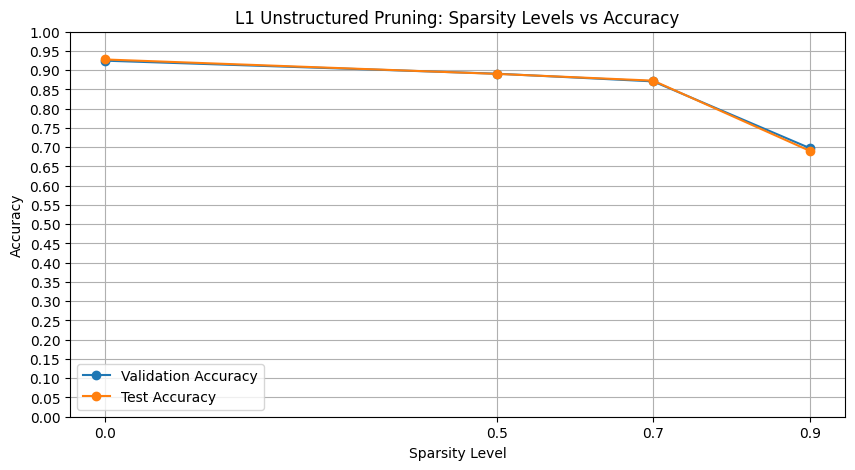

In [6]:
# Plot the sparsity levels vs accuracy for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(unstruct_pruned_amount_metrics_map.keys())
val_accuracies = [mobilenetv2_cifar10_val_accuracy_baseline] + [unstruct_pruned_amount_metrics_map[sparsity]["val_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
test_accuracies = [mobilenetv2_cifar10_test_accuracy_baseline] + [unstruct_pruned_amount_metrics_map[sparsity]["test_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(sparsity_levels, test_accuracies, marker='o', label='Test Accuracy')
plt.title('L1 Unstructured Pruning: Sparsity Levels vs Accuracy')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.ylim(0.0, 1.0)
plt.yticks(torch.linspace(0.0, 1.0, 21).numpy())
plt.show()

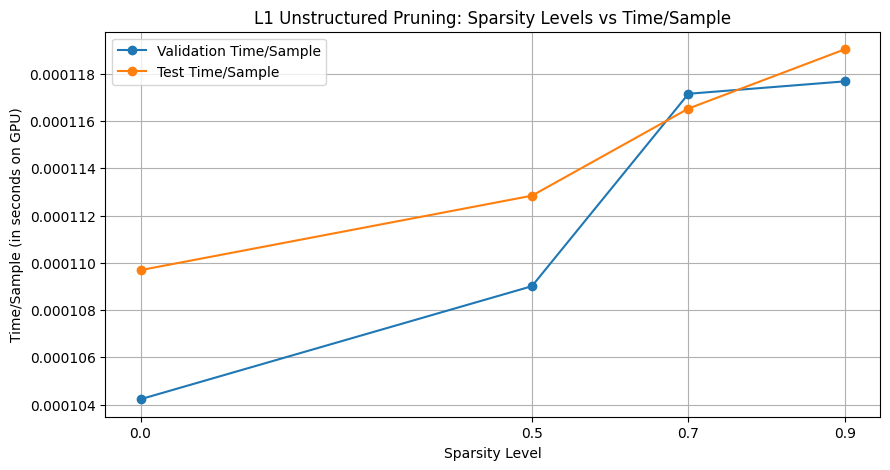

In [7]:
# Plot the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(unstruct_pruned_amount_metrics_map.keys())
val_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["val_metrics"]["avg_time_per_sample"]] + [unstruct_pruned_amount_metrics_map[sparsity]["val_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
test_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["test_metrics"]["avg_time_per_sample"]] + [unstruct_pruned_amount_metrics_map[sparsity]["test_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_time_per_sample, marker='o', label='Validation Time/Sample')
plt.plot(sparsity_levels, test_time_per_sample, marker='o', label='Test Time/Sample')
plt.title('L1 Unstructured Pruning: Sparsity Levels vs Time/Sample')
plt.xlabel('Sparsity Level')
plt.ylabel('Time/Sample (in seconds on GPU)')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

### L1 structured pruning

In [8]:
# Print the sparsity and accuracy results
for sparsity, metrics in struct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Relative Sparsity: {metrics['relative_sparsity']:.2f}, Validation Accuracy: {metrics['val_metrics']['accuracy']:.2f}, Test Accuracy: {metrics['test_metrics']['accuracy']:.2f}")

Sparsity: 0.10, Relative Sparsity: 0.66, Validation Accuracy: 0.88, Test Accuracy: 0.87
Sparsity: 0.30, Relative Sparsity: 0.27, Validation Accuracy: 0.79, Test Accuracy: 0.79
Sparsity: 0.50, Relative Sparsity: 0.10, Validation Accuracy: 0.67, Test Accuracy: 0.66


In [9]:
# Print the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
for sparsity, metrics in struct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Validation Time/Sample: {metrics['val_metrics']['avg_time_per_sample']:.4f}, Test Time/Sample: {metrics['test_metrics']['avg_time_per_sample']:.8f}")

Sparsity: 0.10, Validation Time/Sample: 0.0001, Test Time/Sample: 0.00012278
Sparsity: 0.30, Validation Time/Sample: 0.0001, Test Time/Sample: 0.00009526
Sparsity: 0.50, Validation Time/Sample: 0.0001, Test Time/Sample: 0.00009229


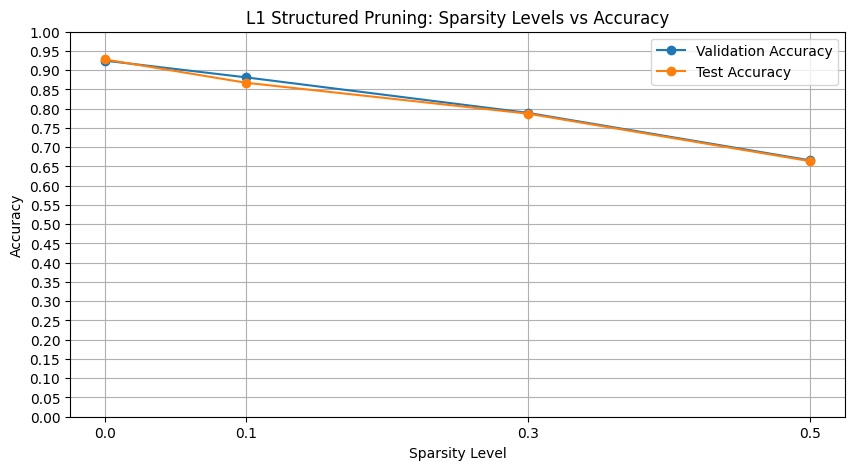

In [10]:
# Plot the sparsity levels vs accuracy for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(struct_pruned_amount_metrics_map.keys())
val_accuracies = [mobilenetv2_cifar10_val_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["val_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
test_accuracies = [mobilenetv2_cifar10_test_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(sparsity_levels, test_accuracies, marker='o', label='Test Accuracy')
plt.title('L1 Structured Pruning: Sparsity Levels vs Accuracy')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.ylim(0.0, 1.0)
plt.yticks(torch.linspace(0.0, 1.0, 21).numpy())
plt.show()

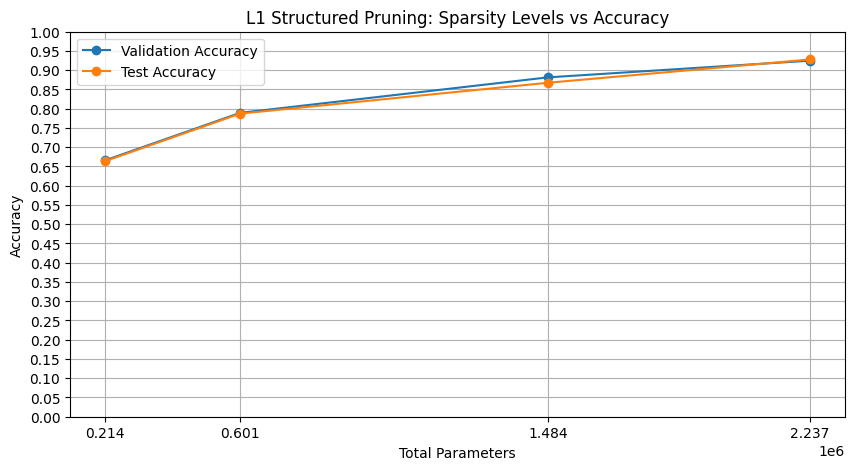

In [11]:
# Plot the total parameters vs accuracy for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(struct_pruned_amount_metrics_map.keys())
total_parameters = [count_parameters(mobilenetv2_cifar10_baseline)["total_params"]] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["params_stats"]["total_params"] for sparsity in sparsity_levels[1:]]
val_accuracies = [mobilenetv2_cifar10_val_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["val_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
test_accuracies = [mobilenetv2_cifar10_test_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(total_parameters, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(total_parameters, test_accuracies, marker='o', label='Test Accuracy')
plt.title('L1 Structured Pruning: Sparsity Levels vs Accuracy')
plt.xlabel('Total Parameters')
plt.ylabel('Accuracy')
plt.xticks(total_parameters)
plt.grid()
plt.legend()
plt.ylim(0.0, 1.0)
plt.yticks(torch.linspace(0.0, 1.0, 21).numpy())
plt.show()

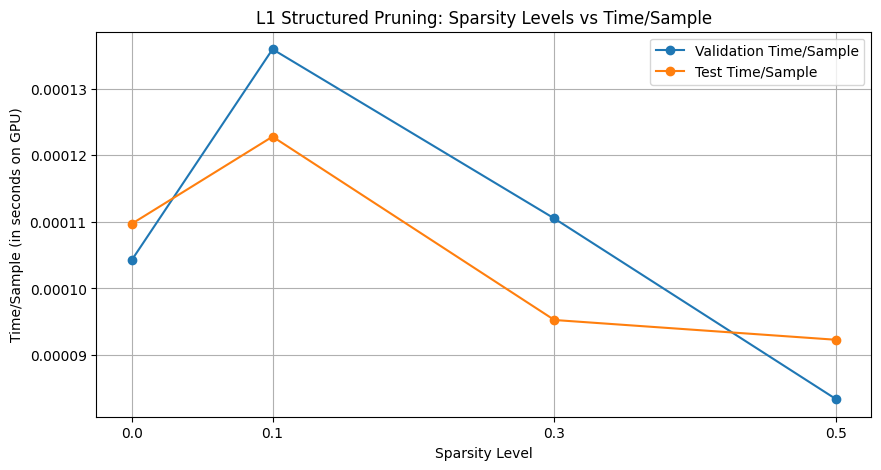

In [12]:
# Plot the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(struct_pruned_amount_metrics_map.keys())
val_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["val_metrics"]["avg_time_per_sample"]] + [struct_pruned_amount_metrics_map[sparsity]["val_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
test_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["test_metrics"]["avg_time_per_sample"]] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_time_per_sample, marker='o', label='Validation Time/Sample')
plt.plot(sparsity_levels, test_time_per_sample, marker='o', label='Test Time/Sample')
plt.title('L1 Structured Pruning: Sparsity Levels vs Time/Sample')
plt.xlabel('Sparsity Level')
plt.ylabel('Time/Sample (in seconds on GPU)')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

## Conclusions

* L1 unstructured pruning is effective at making the model sparse and keeping the accuracy high (up until 90% sparsity where there is a significant drop in accuracy). However, no accelaration is observed nor on GPU or CPU. This is due to  Pytorch's backend that does not support sparse tensors for inference, meaning that the pruned weights are still present in the model and do not lead to reduced computation time.
* L1 structured pruning succeeds also into reducing the model size and inference time (except for an outlier) while keeping the model dense, but at the higher cost of accuracy drop. This is due to the fact that entire channels are removed, which can lead to a more significant loss of information compared to unstructured pruning.
* As libraries and hardware support is often for dense models, structured pruning is often preferred for deployment, as it leads to a more regular model that can be used on standard hardware without requiring specialized libraries. However, unstructured pruning can be used provided that the hardware and libraries used for inference support sparse tensors.